[View in Colaboratory](https://colab.research.google.com/github/ktaletsk/CPF/blob/master/2D_Example/CPF_2D_toy.ipynb)

In [1]:
#@title ##Initialize notebook ▶️ (run this cell, CTRL+SHIFT)
from sympy import *
from sympy.utilities.codegen import codegen
import numpy as np
from IPython.display import Markdown
import matplotlib.pyplot as plt
# import scipy.integrate as integrate
from IPython.display import HTML, Math
from sympy.utilities.lambdify import lambdify
import scipy.integrate

def latex_print(expr):
  display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/" "latest.js?config=default'></script>"))
  return Math(latex(expr))

#Number of dimensions
n=2

%config InlineBackend.figure_format = 'retina'

#Put source files 'FPT-gen.cpp' and 'CPF-gen.cpp' in the same folder as this notebook (for Google Colab)
!git clone https://github.com/ktaletsk/CPF.git; cp CPF/2D_Example/CPF-gen.cpp .; cp CPF/2D_Example/FPT-gen.cpp .; rm -rf CPF

def myKernelDensity(x, h, xi):
    return np.sum(np.exp(-(x-xi)**2/(2*h**2)))/len(xi)
def myKernelDensityDerivative(x, h, xi):
    return np.sum(-(x-xi)/h**2*np.exp(-(x-xi)**2/(2*h**2)))/len(xi)

Cloning into 'CPF'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 83 (delta 41), reused 12 (delta 5), pack-reused 0
Unpacking objects: 100% (83/83), done.


Consider a detailed dynamics, say MD, with the trajectory of some interesting species can reasonably be mapped to dynamics along a single reaction coordinate $x$.
It might then be desirable to coarse grain these simulations to a nonlinear, stochastic differential equation.
It is well established that such dynamics are equivalently described by a Fokker-Planck (or Smoluchowski) equation

\begin{equation}
\frac{\partial p}{\partial t} =
    \frac{\partial}{\partial x}\frac{1}{\zeta} \left[ \left(\frac{dF^\text{CG}}{d x}\right) p
    + k_\text{B}T \frac{\partial p}{\partial x}
    \right],
\end{equation}

where $p\equiv p(x;t|x_0;t_0)$ is the probability density of finding the species in the neighborhood of $x$ at time $t$, given that it had coordinate $x_0$ at some earlier time $t_0$.

The equivalent Ito-form stochastic differential equation is
\begin{equation}
dx = \left( \frac{d \zeta^{-1}}{d x} - \zeta^{-1} \frac{d F}{dx} \right) dt + \sqrt{2 \zeta^{-1}} d W_t
\end{equation}

We are working with 2-dimensional system with free energy in a form:
\begin{equation}
\frac{F(x,y)}{k_B T} = 4(1-x)^2 + 4 \left(y - \frac{\sin a(x-c)}{b}\right)^2
\end{equation}
And friction in the detailed model is the same everywhere:
\begin{equation}
\frac{\zeta(x,y)}{k_B T} = 1
\end{equation}

You can choose parameters for this system below by draging sliders for $a$, $b$ and $c$

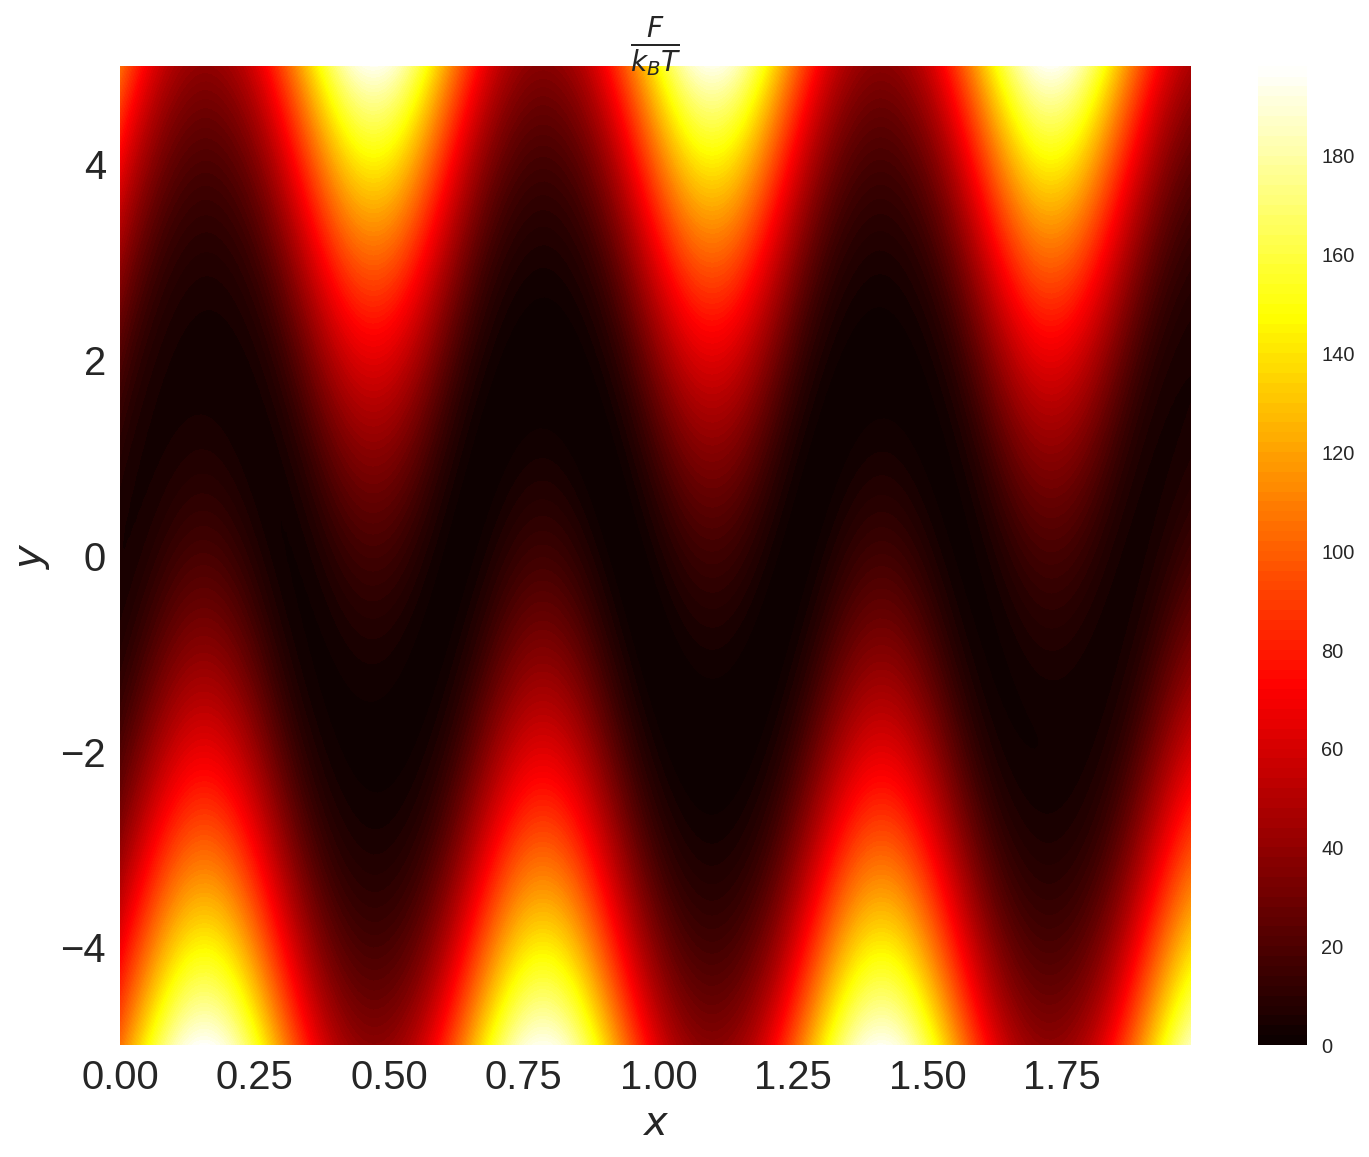

<IPython.core.display.Math object>

In [2]:
#@title Choose frequency, amplitude and phase of walls { display-mode: "form", run: "auto" }
a = 10 #@param {type:"slider", default:8, min:1, max:12, step:0.1}
b = 0.51 #@param {type:"slider", default:0.1, min:0.01, max:2, step:0.1}
c = 0 #@param {type:"slider", default:0, min:-5, max:5, step:0.1}

A = [a]
B = [b]
C = [c]
H = [4, 4]

#Define variables
x = symbols('x0:%d'%n)

def floor(x,A,B,C):
    return sin(A*(x-C))/B

def wall(x,y,A,B,C):
    return (y - floor(x,A,B,C))**2

def free_energy(n, x):
    result = H[0]*(1-x[0])**2
    for i in range(1, n):
        result += H[i] * wall(x[0], x[i], A[i-1], B[i-1], C[i-1])
    return result

def free_energy_CG(x):
    return H[0]*(1-x[0])**2

def zeta_inv(n, x):
    return 1 #Constant friction

def tshift(n,x,i):
    return diff(zeta_inv(n,x), x[i])-zeta_inv(n, x)*diff(free_energy(n,x), x[i])

def wshift(n,x):
    return sqrt(2.0*zeta_inv(n, x))

#Numerical distribution functions
pCG = lambdify(x[0], exp(-free_energy_CG(x))/simplify(integrate(exp(-free_energy_CG(x)),(x[0],-oo,oo))), "sympy")
PCG = lambdify(x[0], simplify(integrate(exp(-free_energy_CG(x)),(x[0],-oo,x[0])))/simplify(integrate(exp(-free_energy_CG(x)),(x[0],-oo,oo))), "sympy")

func = lambdify(x, free_energy(n, x),'numpy') # returns a numpy-ready function
Xplot = np.arange(0,2,0.01)
Yplot = np.arange(-5,5,0.01)
X, Y = np.meshgrid(Xplot, Yplot)
F = func(X, Y)
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(111)
CS3 = plt.contourf(X, Y, F, 100, cmap=plt.cm.hot)
fig.colorbar(CS3, ax=ax1)
ax1.set_title(r'$\frac{F}{k_B T}$')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(20)
plt.show()
latex_print(r'\frac{F}{k_B T} =' + latex(free_energy(n, x)))

You can see the free energy lanscape for detailed model from above, darker regions represent low free energy, bright regions represent high free energy and pose obstacles for diffusing Brownian particles

In [0]:
#@title ##Generate simulation program ▶️
#Generate Ito-stochastic-equation
xx = MatrixSymbol('x', 1, n)
dx = MatrixSymbol('dx', 1, n)
dWt = MatrixSymbol('dWt', 1, n)
dt = symbols('dt')
subs_rule = list(zip(x,xx))
array = [(tshift(n,x,i) * dt + wshift(n,x) * dWt[i]).subs(subs_rule) for i in range(n)]
m = Matrix(1, n, array)
equation = Eq(dx, m)

#Calculate equilibrium distribution
p = symbols('p0:%d'%(n-1))
pp = MatrixSymbol('p', 1, n)
xx = MatrixSymbol('x', 1, n)
xa = symbols('xa')

subs_rule2 = list(zip(p,pp))
subs_rule2.insert(0,(x[0],xa))
array2 = [(floor(x[0],A[i],B[i],C[i]) + p[i]/sqrt(2*H[i+1])).subs(subs_rule2)  for i in range(0,n-1)]
array2.insert(0,xa)
m2 = Matrix(1, n, array2)
equation2 = Eq(xx, m2)

#Generate code for timestep and initialization
codegen(("shift",equation), "C", "shift", header=False, empty=False, to_files=True)
codegen(("init",equation2), "C", "init", header=False, empty=False, to_files=True)

#Compile simulation code
! g++ FPT-gen.cpp shift.c init.c -o FPT-gen
! g++ CPF-gen.cpp shift.c init.c -o CPF-gen

In [0]:
!./CPF-gen

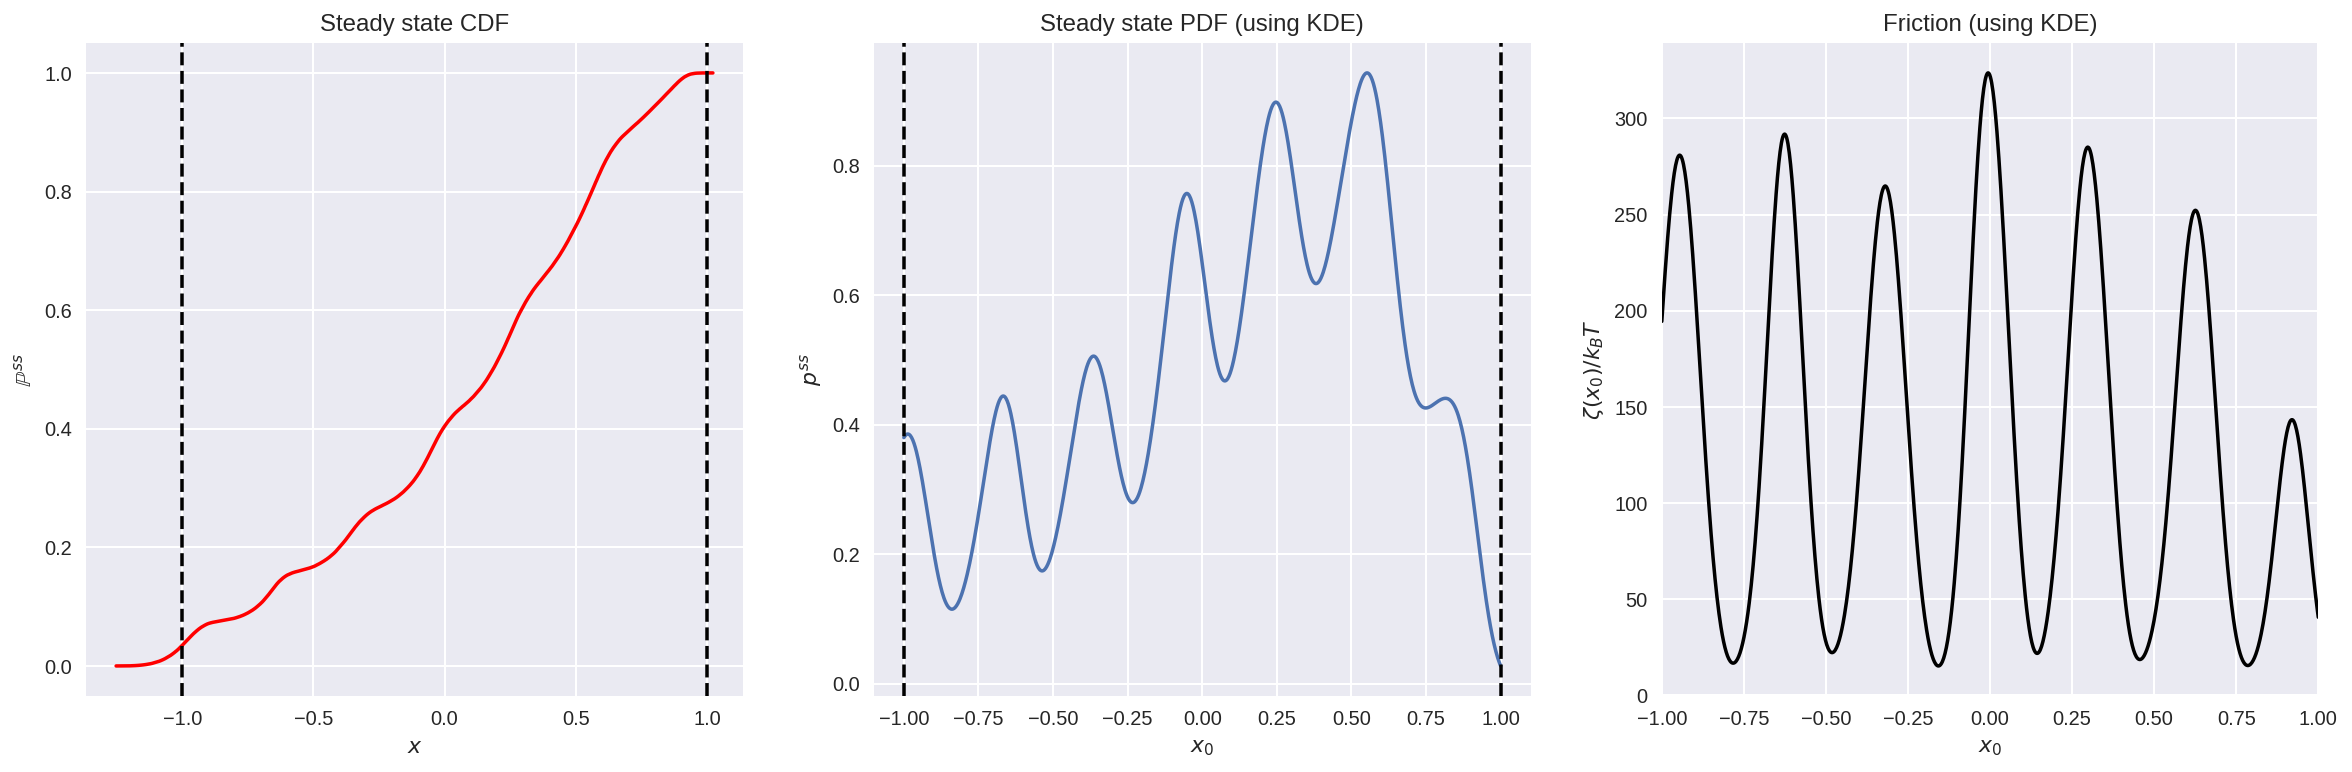

In [5]:
#@title ##Processing CPF results ▶️

#Read steady state CDF
with open('cpf.dat') as f:
    lines = f.readlines()
    x0 = np.array([float(line.split()[0]) for line in lines])
    x0.sort()
    
#Read flux results
with open('flux.dat') as f:
    lines = f.readlines()
J0 = float(lines[-1].split()[1])/float(lines[-1].split()[0])

#Calculate steady state CDF
P = np.arange(0.0, 1.0, 1.0/x0.shape[0])

# Use Kernel Density Estimation to find steady state PDF
#Rule of thumb bandwith for kernel density estimstor
h = 1.06*np.std(x0)*np.size(x0)**(-0.2)

X_plot = np.linspace(-1.0, 1.0, 1000)
mydens = [myKernelDensity(i, h, x0) for i in X_plot]
mydensder = [myKernelDensityDerivative(i, h, x0) for i in X_plot]

dFdx = lambdify(x[0],diff(free_energy_CG(x)))
friction = [-(myKernelDensity(i, h, x0)*dFdx(i)+myKernelDensityDerivative(i, h, x0))/J0/np.sqrt(2*np.pi*h**2) for i in X_plot]

fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(131)
ax1.set_title("Steady state CDF")
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\mathbb{P}^{ss}$')
ax1.plot(x0,P, c='r', label=r'$f_d(t)$')
plt.axvline(x=-1, color='k', linestyle='--')
plt.axvline(x=1,  color='k', linestyle='--')

ax2 = fig.add_subplot(132)
ax2.set_title("Steady state PDF (using KDE)")
ax2.set_xlabel(r'$x_0$')
ax2.set_ylabel(r'$p^{ss}$')
ax2.plot(X_plot, np.array(mydens)/np.sqrt(2*np.pi*h**2), label=r'$p^{ss}$')
plt.axvline(x=-1, color='k', linestyle='--')
plt.axvline(x=1,  color='k', linestyle='--')

ax5 = fig.add_subplot(133)
ax5.set_title("Friction (using KDE)")
ax5.set_xlabel(r'$x_0$')
ax5.set_ylabel(r'$\zeta(x_0)/k_B T$')
ax5.plot(X_plot, np.array(friction), c='k', label='dpss/dx')
plt.xlim(xmin=-1, xmax=1)

plt.show()

#Mean first passage time predictions

In [0]:
xr=1
arr1 = np.array([(N(PCG(xr))-N(PCG(xT)))/N(pCG(xT))/J0 for xT in X_plot], dtype="float")
fpt_cpf = [scipy.integrate.quad(lambda x: -(PCG(x)-PCG(1))/pCG(x), xT, 1)[0] for xT in X_plot]

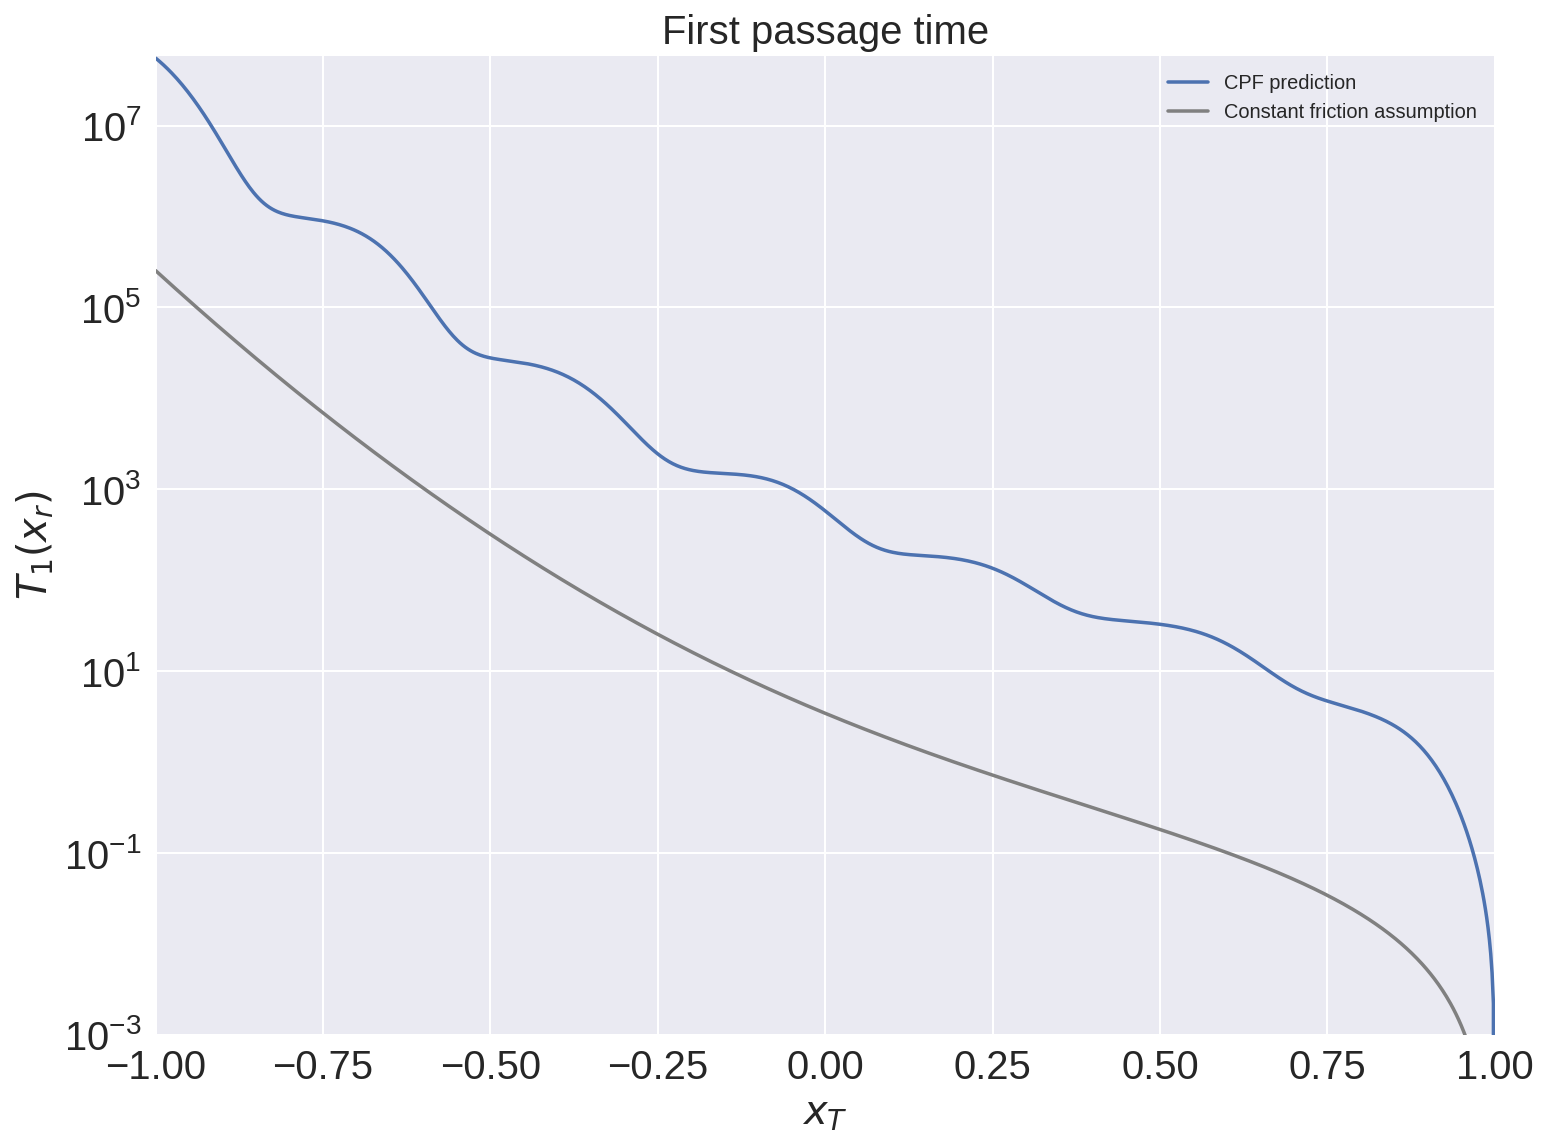

In [7]:
fig4 = plt.figure(figsize=(12, 9))

ax4 = fig4.add_subplot(111)

ax4.set_title("First passage time")
ax4.set_xlabel(r'$x_T$')
ax4.set_ylabel(r'$T_1(x_r)$')

ax4.plot(X_plot, np.array(mydens)/np.sqrt(2*np.pi*h**2)*arr1, label='CPF prediction')
ax4.plot(X_plot, fpt_cpf, c='gray', label='Constant friction assumption')
# ax4.scatter(np.arange(1,-0.8,-0.05), fpt_bd_mean[1:], facecolors='none', edgecolors='r')
#ax4.errorbar(np.arange(1.0,-1.05,-0.05), fpt_bd_mean, yerr=fpt_bd_stderr, c='r', fmt='o')
plt.xlim(xmin=-1, xmax=1)
plt.ylim(ymin=1e-3)
leg = ax4.legend()
ax4.set_yscale('log')

for item in ([ax4.title, ax4.xaxis.label, ax4.yaxis.label] +
             ax4.get_xticklabels() + ax4.get_yticklabels()):
    item.set_fontsize(20)

plt.show()

In [0]:
#Detailed model predictions
#This simulation can take a long time
!./FPT-gen 0